In [1]:
from datasets.CustomImageDataset import CustomImageDataset
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset, ConcatDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

from models.cnn import CnnModel
from train import mlp_train
from utils import plot_model_metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 512
dataset = CustomImageDataset('data/DeepHP', class_size=1_000)

train_dataset, test_dataset = random_split(dataset, [0.7, 0.3])
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True, )
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, )

model = CnnModel()
print(model)


cuda:0
CnnModel(
  (model): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(3, 3), padding=valid)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(3, 3), padding=valid)
    (11): ReLU()
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(3, 3), padding=valid)
    (13): ReLU()
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1296, out_features=200, bias=True)
    (16): ReLU()
    (17): Linear(in_features=200, out_features=50, bias=True)
    (18): ReLU()
    (19): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [2]:

model = model.to(device)
model, model_metrics = mlp_train(model, train_loader, test_loader, device,
                                 learning_rate=0.001,
                                 max_epochs=50)

100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


Test accuracy: 0.49449943236087385
Test precision: 0.5274079726789168
Test recall: 0.5014113053145816
Test f1: 0.49382091933069167


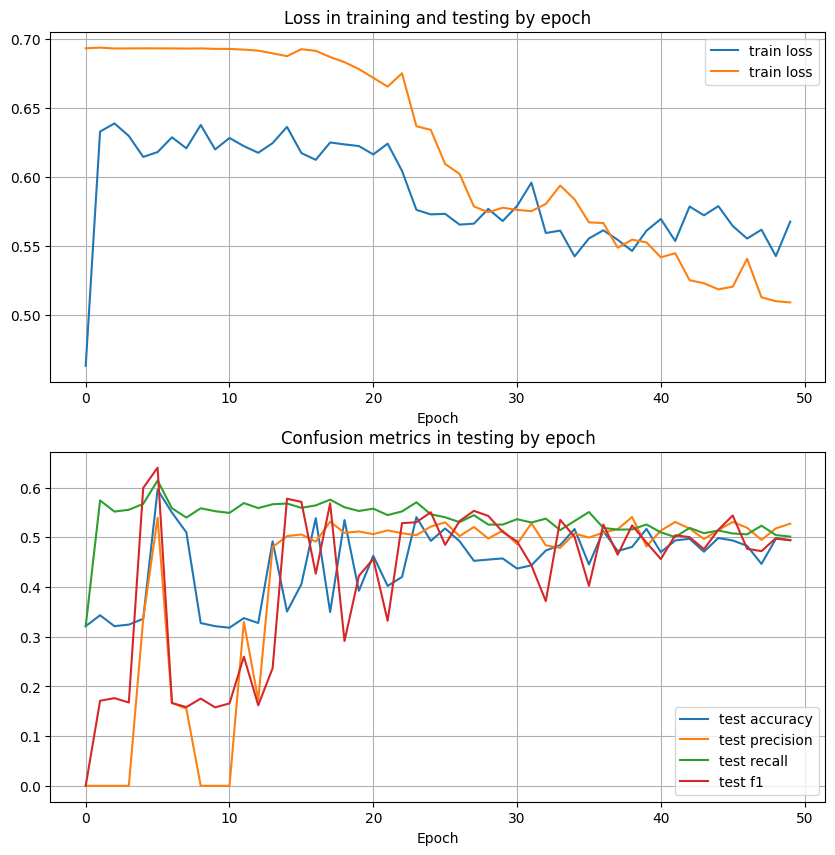

In [3]:

# print(model_metrics)
for metric in ["accuracy", "precision", "recall", "f1"]:
    print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [4]:

torch.save(model.state_dict(), "./model5.bin")
